In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))
import pymatting
from pymatting import cutout

import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import torch.nn as nn
import numpy as np
from skimage import img_as_ubyte
import imageio
import json
import cv2
import time
from PIL import Image
from pytorch3d.loss import (
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch.nn.functional as F

from tqdm import tqdm_notebook
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj
import math
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures, join_meshes_as_batch
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    SfMPerspectiveCameras,
    SfMOrthographicCameras,
    PointLights, 
    BlendParams,
    DirectionalLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftSilhouetteShader,
    look_at_rotation,
    HardFlatShader
)

# add path for demo utils functions 
import sys
import os
import glob
sys.path.append(os.path.abspath(''))

print(torch.version.cuda)
from datetime import datetime
def now_str():
    now = datetime.now()
    month = str(now.month)
    day = str(now.day)
    hour = str(now.hour)
    minute = str(now.minute)
    sec = str(now.second)
    
    output = '[{:>02}/{:>02} {:>02}:{:>02}:{:>02}]'.format(month, day, hour, minute, sec)
    return output
def __output_log(path, strs):
    if not os.path.exists(path):
        with open(path, 'w+') as f:
            f.write(strs)
            f.close()
    else:
        with open(path, 'a+') as f:
            f.write(strs)
            f.close()
print(now_str())
print(torch.__version__)

def reproject(params, vertices, distort=False):
    R = params['R']
    T = params['T']
    fx = params['fx']
    fy = params['fy']
    cx = params['cx']
    cy = params['cy']

    E = np.array([
        [R[0,0], R[0,1], R[0,2], T[0]], 
        [R[1,0], R[1,1], R[1,2], T[1]], 
        [R[2,0], R[2,1], R[2,2], T[2]], 
        [0, 0, 0, 1]]).astype('double')
    
    if distort:
        k1 = params['k1']
        k2 = params['k2']
        k3 = params['k3']
        p1 = params['p1']
        p2 = params['p2']
        
    img_pts = []
    for i in range(len(vertices)):
        v = np.array(vertices[i])

        # extrinsics
        v4 = E.dot(np.array([v[0], v[1], v[2], 1]).astype('double'))
        xp = v4[0] / v4[2]
        yp = v4[1] / v4[2]

        if distort:
            # intrinsics
            r2 = xp**2 + yp**2
            ## radial
            radial_dist = 1 + k1*(r2) + k2*(r2*r2) + k3*(r2*r2*r2)

            ## tangential
            tan_x = p2 * (r2 + 2.0 * xp * xp) + 2.0 * p1 * xp * yp
            tan_y = p1 * (r2 + 2.0 * yp * yp) + 2.0 * p2 * xp * yp

            xp = xp * radial_dist + tan_x
            yp = yp * radial_dist + tan_y
            
        u = fx * xp + cx
        v = fy * yp + cy
        pr = 1
        nr = 0
        if (-4000*nr < u and u < pr*4000) and (-2160*nr < v and v < pr*2160):
            img_pts.append(np.array([u, v]))
    img_pts = np.array(img_pts)
    return img_pts

9.2
[05/17 19:32:53]
1.4.0


In [2]:
device = torch.device("cuda:0")

cams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
cam_path = r'D:\CalibrationData\CameraCalibration\2019_12_13_Lada_Capture_k1k2k3p1p2\FinalCamParams\cam_params.json'
mesh_dir = r'./9_data/input/vt_added'
#img_dir = './9_data/input'
img_dir = 'D:/Pictures/2019_12_13_Lada_Capture/RGB/rgbPng'
# img_names = ['03052', '03990', '04917', '06950']
# img_names = ['03052', '03990', '04917', '06950']
img_names = ['03052', '04917']
clean_plate_dir = r'D:\Pictures\2019_12_13_Lada_Capture\CleanPlates\undistorted'
texturemap_path = r'./14d_data/output/200515_lessShadingInfo/texturemap_averaged.npy'

texturemap_shape = (1024, 1024, 1)
image_size = 1080

# input image size
actual_img_shape = (2160, 4000)

mesh_paths_ = glob.glob(mesh_dir + '/*.obj')
mesh_paths = []
print('Meshes:')
for p in mesh_paths_:
    for img_name in img_names:
        if img_name in p:
            mesh_paths.append(p)
            print(' ', p)
n_forwards = len(img_names)*len(cams)
print('{} renderes'.format(n_forwards))

image_data = []
for img_name in img_names:
    for cam_idx in range(16):
        image_data.append({'img_name': img_name, 'cam_idx': cam_idx})

Meshes:
  ./9_data/input/vt_added\03052Interpo_mm.obj
  ./9_data/input/vt_added\04917Interpo_mm.obj
32 renderes


# load cameras

In [3]:
def load_cameras(cam_path, device, actual_img_shape):
    print('actual_img_shape:',actual_img_shape)
    h = actual_img_shape[0]
    w = actual_img_shape[1]
    img_size = min(w, h)
    
    # load cameras
    cams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']

    with open(cam_path, 'r') as f:
        j = json.load(f)
        camera_params = j['cam_params']

    cam_params = []
    Rs, Ts, focal_lengths, principal_points = [], [], [], []
    for cam_idx, cam in enumerate(cams):
        cam_param = camera_params[str(cam_idx)]
        # for undistortion
        fx = cam_param['fx']
        fy = cam_param['fy']
        cx = cam_param['cx']
        cy = cam_param['cy']
        k1 = cam_param['k1']
        k2 = cam_param['k2']
        k3 = cam_param['k3']
        p1 = cam_param['p1']
        p2 = cam_param['p2']
        
        rvec = np.float32(cam_param['rvec'])
        T = np.float32(cam_param['tvec'])
        R, _ = cv2.Rodrigues(rvec)
        Rs.append(R.T)
        Ts.append(T)
        
        cx_corrected = cx*2/img_size - w/img_size
        cy_corrected = cy*2/img_size - h/img_size
        fx_corrected = fx*2/img_size
        fy_corrected = fy*2/img_size
        principal_point = np.array([cx_corrected, cy_corrected]).astype(np.float32)
        focal_length = np.array([fx_corrected, fy_corrected]).astype(np.float32)
        focal_lengths.append(focal_length)
        principal_points.append(principal_point)

        K = np.float32([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
        dist = np.float32([k1, k2, p1, p2, k3])
        cam_params.append({'K': K, 'dist': dist, 'R': R, 'T': T, 'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy})
    
    R_torch = torch.from_numpy(np.array(Rs).astype(np.float32))
    T_torch = torch.from_numpy(np.array(Ts).astype(np.float32))
    focal_length = torch.from_numpy(np.array(focal_lengths).astype(np.float32))
    principal_point = torch.from_numpy(np.array(principal_points).astype(np.float32))
    out_for_torch = {'R': R_torch, 'T': T_torch, 'fl': focal_length, 'pp': principal_point}
    return cam_params, out_for_torch

cam_params, cams_torch = load_cameras(cam_path, device, actual_img_shape)
print(len(cam_params), ':', cam_params[0].keys())
print(cams_torch.keys())

actual_img_shape: (2160, 4000)
16 : dict_keys(['K', 'dist', 'R', 'T', 'fx', 'fy', 'cx', 'cy'])
dict_keys(['R', 'T', 'fl', 'pp'])


# load target, bg images

In [4]:
def load_images(img_dir, img_names):
    image_refs_out = {}
    crops_out = {}
    
    w = 2160 / 2
    for img_name in img_names:
        #path = img_dir + '/{}/images/undistorted'.format(img_name)
        path = img_dir + '/{}'.format(img_name)
        img_paths = sorted(glob.glob(path + '/*.png'))
        image_refs_undistort = []
        for i, path in enumerate(img_paths):
            #img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
            img = cv2.imread(path).astype(np.float32) / 255.0
            image_refs_undistort.append(img)

        image_refs_cropped = []
        for i in range(len(image_refs_undistort)):
            image = image_refs_undistort[i]
            cx = image.shape[1] / 2

            image = image_refs_undistort[i]
            img = image[:, int(cx-w):int(cx+w)]
            img = cv2.resize(img, (image_size, image_size))
            img = cv2.flip(img, -1)
            image_refs_cropped.append(img)
        image_refs_out[img_name] = image_refs_undistort
        crops_out[img_name] = image_refs_cropped
    return image_refs_out, crops_out

img_refs_undistorted, img_refs = load_images(img_dir, img_names)
print('img_refs_undistorted:', img_refs_undistorted.keys())
print('  {}'.format(img_refs_undistorted[list(img_refs_undistorted.keys())[0]][0].shape))
print('img_refs:', img_refs.keys())
print('  {}'.format(img_refs[list(img_refs.keys())[0]][0].shape))

img_refs_undistorted: dict_keys(['03052', '04917'])
  (2160, 4000, 3)
img_refs: dict_keys(['03052', '04917'])
  (1080, 1080, 3)


In [5]:
def load_clean_plates(img_dir, cam_params):
    img_paths = sorted(glob.glob(img_dir + '/*.PNG'))
    images0 = []
    images_undistort = []
    for i, path in enumerate(img_paths):
        # img = imageio.imread(path)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
        images0.append(img)
        images_undistort.append(img)

    w = 2160 / 2
    clean_plates_cropped = []
    for i in range(len(images_undistort)):
        image = images_undistort[i]
        cx = image.shape[1] / 2

        image = images_undistort[i].astype(np.float32)
        img = image[:, int(cx-w):int(cx+w)]
        img = cv2.resize(img, (image_size, image_size))
        img = cv2.flip(img, -1)
        # img = np.dstack([img, img, img])
        clean_plates_cropped.append(img)
    
    return images0, images_undistort, clean_plates_cropped 

clean_plates_original, clean_plates_undistort, clean_plates = load_clean_plates(clean_plate_dir, cam_params)
print('clean_plates_original:', clean_plates_original[0].shape)

clean_plates_original: (2160, 4000)


# Model

In [9]:
class Model_normal(nn.Module):
    def __init__(self, device, **kwargs):
        super().__init__()
        self.batch_size = kwargs.get('batch_size', None)
        assert(self.batch_size == 1) # for multiple lights
        
        self.device = device
        self.cams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
        self.n_cams = len(self.cams)
        self.image_size = kwargs.get('image_size', None)
        image_refs = kwargs.get('image_refs', None).copy()
        self.image_refs = {}
        
        for img_name, img_list in image_refs.items():
            # (16, 1080, 1080, 1)
            # imgs_torch = torch.from_numpy(np.array(img_list).astype(np.float32)).unsqueeze(-1).to(self.device)
            imgs_torch = torch.from_numpy(np.array(img_list).astype(np.float32)).to(self.device)
            self.image_refs[img_name] = imgs_torch
            
        # set clean_plates:
        clean_plates = kwargs.get('clean_plates', None)
        if clean_plates is not None:
            # (16, 1080, 1080, 1)
            self.clean_plates = torch.from_numpy(np.array(clean_plates).astype(np.float32)).unsqueeze(-1).to(self.device)
        
        # load texturemaps: [0.0, 1.0] float
        texturemap_path = kwargs.get('texturemap_path', None)
        texturemap_shape = kwargs.get('texturemap_shape', None)
        if texturemap_path is not None:
            if '.png' in texturemap_path:
                texturemap = imageio.imread(texturemap_path) / 255.0
            elif '.npy' in texturemap_path:
                texturemap = (np.load(texturemap_path).squeeze() * 255).astype(np.uint8)
                texturemap = (texturemap/255.0).astype(np.float32)
            texture_map_torch = torch.from_numpy(texturemap).unsqueeze(0).unsqueeze(-1).float()
        else:
            texture_map_torch = torch.from_numpy(np.ones((1, texturemap_shape[0], texturemap_shape[1], 1)).astype(np.float32))
        self.texture_map = nn.Parameter(texture_map_torch.to(self.device), requires_grad=True)
        print(self.texture_map.shape)

        # batch_size
        self.batch_dict = {'img_name': [], 'cam_idx': [], 'mesh_idx': []}
        i = 0
        for img_name in self.image_refs.keys():
            for cam_idx in range(self.n_cams):
                self.batch_dict['img_name'].append(img_name)
                self.batch_dict['cam_idx'].append(cam_idx)
                self.batch_dict['mesh_idx'].append(i)
            i += 1

        # ====================
        # lights & renderers
        # ====================
        self.n_lights = 4
        dtheta = 2*np.pi / self.n_lights
        thetas = np.float32([light_idx*dtheta for light_idx in range(self.n_lights)]) # 0=0 deg, 1=2*np.pi
        phis = np.float32([np.pi/3.0]*self.n_lights) # 0=0 degree, 1=np.pi/2 degree
        radiuses = np.float32([1000.0*2.25]*self.n_lights) # [meter], interpolate between (2, 2.5) meter (ground-truth = 2.25m)
        light_coords = torch.from_numpy(np.stack([thetas, phis, radiuses])).to(self.device)
        xyz = self.unit_spherical_to_cartesian(light_coords)
        
        # fixed light brightness
        diffuse = 0.32659074664115906
        ambient = 0.2800530195236206
        specular = 0.46927517652511597
        s = specular*torch.from_numpy(np.ones((1, 3)).astype(np.float32)).to(self.device)
        d = diffuse *torch.from_numpy(np.ones((1, 3)).astype(np.float32)).to(self.device)
        a = ambient *torch.from_numpy(np.ones((1, 3)).astype(np.float32)).to(self.device)
        light = PointLights(device=self.device, location=xyz, specular_color=s, ambient_color=a, diffuse_color=d)
        light.specular_color = s
        light.diffuse_color = d
        light.ambient_color = a
        shader = TexturedSoftPhongShader(
                    device=self.device, 
                    cameras=None,
                    lights=light,
                    blend_params=BlendParams(sigma=1e-4, gamma=1e-4)
                )
        # init renderers
        self.renderer = self._init_renderer(shader)
        
        # camera batches
        self.cam_params = kwargs.get('cam_params', None)
        self.n_batch = kwargs.get('n_batch', None)
        self.cam_batches = self._init_camera_batches(self.cam_params, batch_dict=self.batch_dict, n_batch=self.n_batch, batch_size=self.batch_size)

        # set mesh
        mesh_paths = kwargs.get('mesh_paths', None)
        self.meshes = self._load_meshes_list(self.device, mesh_paths=mesh_paths, texture_map=texture_map_torch.float())
        
        # vertex deformations
        nverts = self.meshes[0].verts_normals_packed()
        dnormal = torch.from_numpy(np.zeros((nverts.shape[0], 1), dtype=np.float32))
        self.dnormals = nn.Parameter(dnormal.to(self.device), requires_grad=True)
        print('self.dnormals:', self.dnormals.shape, ', nverts:', nverts.shape)
          
    def _init_renderer(self, shader):
        raster_settings = RasterizationSettings(
            image_size=self.image_size, 
            blur_radius=0.0, 
            faces_per_pixel=1, 
            bin_size = 0, # this setting controls whether naive or coarse-to-fine rasterization is used
            max_faces_per_bin = None  # this setting is for coarse rasterization
        )
        renderer = MeshRenderer(
                rasterizer=MeshRasterizer(
                    cameras=None,
                    raster_settings=raster_settings
                ),
                shader=shader
            )
        return renderer
    
    def deform_meshes(self):
        self.deformed_meshes = []
        for i in range(len(self.meshes)):
            deform_verts = self.dnormals * self.meshes[i].verts_normals_packed()
            self.deformed_meshes.append(self.meshes[i].offset_verts(deform_verts))
    
    def set_mesh_texturemap(self):
        for i in range(len(self.meshes)):
            self.meshes[i].textures_maps_padded = self.texture_map.float()
        
    def forward(self, batch_idx, learn_texturemap: bool, learn_deform: bool):
        losses = {'total': 0.0, 'pixel': 0.0, 'laplacian': 0.0}
        
        self.dnormals.requires_grad = learn_deform
        self.texture_map.requires_grad = learn_texturemap
        
        # ==================================================================================== #
        # minibatch training
        i0 = batch_idx*self.batch_size
        i1 = i0 + self.batch_size

        cam_indices = self.batch_dict['cam_idx'][i0:i1]
        mesh_indices = self.batch_dict['mesh_idx'][i0:i1]
        img_names = self.batch_dict['img_name'][i0:i1]
        
        cam_batch = self.cam_batches[batch_idx]
        meshes = [self.deformed_meshes[i] for i in mesh_indices]
        meshes = join_meshes_as_batch(meshes)
        meshes = meshes.extend(self.n_lights)
        image_cur = self.renderer(meshes_world=meshes, texture_maps=self.texture_map, cameras=cam_batch)
        image_cur = torch.mean(image_cur, dim=0).unsqueeze(0)
        
        # shape (batch_size, W, H)
        bgs = self.clean_plates[cam_indices].squeeze()

        # merge fg, bg, single channel
        image_cur_gray = self._merge_fg_bg(image_cur, bgs)

        # [0, 0.1] float32
        image_refs = torch.stack([self.image_refs[img_names[i]][cam_indices[i]] for i in range(self.batch_size)]).to(self.device)
        l_pixel = torch.mean(torch.abs(image_cur_gray - image_refs))
        l_laplacian = 0.0005*mesh_laplacian_smoothing(meshes, method="cotcurv")

        loss = l_pixel + l_laplacian
        losses['pixel'] += (l_pixel.data / self.batch_size / self.n_batch)
        losses['laplacian'] += (l_laplacian.data / self.batch_size / self.n_batch)
        losses['total'] += (loss.data / self.batch_size / self.n_batch)
        images_out = {'currents_with_bg': image_cur_gray, 'currents': image_cur, 'targets': image_refs}
        # ==================================================================================== #
        
        return images_out, loss, losses
    
    
    def unit_spherical_to_cartesian(self, light_coords):
        """
        z-up, phi w.r.t. +z axis, theta w.r.t. +x axis
        """
        thetas = light_coords[0, :]
        phis = light_coords[1, :]
        radiuses = light_coords[2, :]
        
        r = radiuses * torch.sin(phis)
        z = radiuses * torch.cos(phis)
        x = r * torch.cos(thetas)
        y = r * torch.sin(thetas)
        
        xyz = torch.stack([x, y, z], dim=1)
        return xyz    
        
    def _merge_fg_bg(self, fg, bg):
        """
        fg: mesh rendering. [N, W, H, 4]: [0, 1.0] float
        bg: clean plate. [N, W, H, 1]: [0, 1.0] float
        out: [N, W, H, 4]
        """
        out = torch.where(fg[..., 3] > 0.0, fg[..., 0], bg).unsqueeze(-1)
        if len(out.shape) < 3:
            out = out.unsqueeze(0)
        return out

    def get_gpu_stats(self, output_str=True):
        mb_reserved = torch.cuda.memory_reserved() * 0.000001
        mb_alloc = torch.cuda.memory_allocated() * 0.000001
        mb_alloc_max = torch.cuda.max_memory_allocated() * 0.000001
        mb_cached = torch.cuda.memory_cached() * 0.000001
        mb_cached_max = torch.cuda.max_memory_cached() * 0.000001
        
        if output_str:
            return 'alloc={:,.0f}MB | cached={:,.0f}MB | reserved={:,.0f}MB'.format(mb_alloc, mb_cached, mb_reserved)
        else:
            return mb_alloc, mb_cached, mb_reserved
    
    def _load_meshes_list(self, device, mesh_paths, texture_map):
        meshes_list = []
        for path in mesh_paths:
            verts, faces, aux = load_obj(path)
            faces_idx = faces.verts_idx

            verts_uvs = aux.verts_uvs[None, ...].to(device)  # (1, V, 2)
            faces_uvs = faces.textures_idx[None, ...].to(device)  # (1, F, 3)
            textures = Textures(maps=texture_map, faces_uvs=faces_uvs, verts_uvs=verts_uvs)

            mesh = Meshes(
                verts=[verts.to(device)],   
                faces=[faces_idx.to(device)], 
                textures=textures.to(device)
            )

            meshes_list.append(mesh)
        return meshes_list
    
    
    def _convert_mesh_into_batches(self, meshes):
        mesh_batches = []
        for batch_idx in range(self.n_batch):
            i0 = batch_idx*self.batch_size
            i1 = i0 + self.batch_size
            meshes_join = []
            for i in self.batch_dict['mesh_idx'][i0:i1]:
                meshes_join.append(meshes[i])
            mesh_batch = join_meshes(meshes_join, include_textures=True)
            mesh_batches.append(mesh_batch)
        return mesh_batches
    
    def save_parameters(self, out_path):
        deform_verts = self.deform_verts.detach().cpu().numpy()
        np.save(out_path, deform_verts)
        print('Parameters saved:', out_path)
        
    def load_parameters(self, in_path):
        self.deform_verts = nn.Parameter(torch.from_numpy(np.load(in_path)).to(self.device))
        print('Parameters loaded: {}'.format(self.deform_verts.shape))
        
    def export_obj(self, out_dir, vt_path=None, export_texturemap=False, fname_suffix=''):
        out_name = 'mesh_deformed'

        # export texturemap
        if export_texturemap:
            tm = model.texture_map.clone().squeeze().detach().cpu().numpy()
            if tm is not None:
                tm = (255.0*tm).astype(np.uint8)
                im = Image.fromarray(tm)
                out_path = out_dir + '/texturemap_learned.png'
                im.save(out_path, dpi=(600, 600))
                print('texturemap saved to:', out_path)

        # export mtl
        with open(out_dir + '/{}.mtl'.format(out_name), 'w+') as f:
            f.write('map_Kd texturemap_learned.png\n')
            f.write('newmtl None\n')
            f.write('Ns 500\n')
            f.write('Ka 0.8 0.8 0.8\n')
            f.write('Kd 0.8 0.8 0.8\n')
            f.write('Ks 0.8 0.8 0.8\n')
            f.write('d 1\n')
            f.write('illum 2')
            f.close()

        vt_lines = []
        f_lines = []
        if vt_path is not None:
            with open(vt_path, 'r') as f:
                lines = f.readlines()
                for l in lines:
                    v = l.split(' ')
                    if v[0] == 'vt':
                        vt_lines.append(l)
                    elif v[0] == 'f':
                        f_lines.append(l)

        out_name = 'mesh_deformed'
        for mesh_idx in range(len(self.meshes)):
            out_path = out_dir + '/{}_{}{}.obj'.format(out_name, mesh_idx, fname_suffix)
            dverts = self.dnormals * self.meshes[mesh_idx].verts_normals_packed()
            deformed_mesh = self.meshes[mesh_idx].offset_verts(dverts)

            verts = deformed_mesh.verts_packed()
            faces = deformed_mesh.faces_packed()
            vnormals = deformed_mesh.verts_normals_list()[0]
            fnormals = deformed_mesh.faces_normals_list()[0]

            assert(faces.shape[0] == fnormals.shape[0])
            assert(vnormals.shape[0] == verts.shape[0])

            with open(out_path, 'w+') as f:
                f.write('# OBJ file created by Hyojoon Park.\n')
                f.write('###########################\n')
                f.write('# Vertices:       {}\n'.format(verts.shape[0]))
                f.write('# Vertex normals: {}\n'.format(vnormals.shape[0]))
                f.write('# Faces:          {}\n'.format(faces.shape[0]))
                f.write('###########################\n')
                f.write('mtllib {}.mtl\n'.format(out_name))
                for i in range(verts.shape[0]):
                    f.write('vn {} {} {}\n'.format(vnormals[i][0], vnormals[i][1], vnormals[i][2]))
                    f.write('v {} {} {}\n'.format(verts[i][0], verts[i][1], verts[i][2]))
                    
                for vtl in vt_lines:
                    f.write(vtl)
                    
                if len(f_lines) > 0:
                    for fl in f_lines:
                        f.write(fl)
                else:
                    for i in range(faces.shape[0]):
                        f.write("f")
                        face = faces[i, :]
                        for fi in range(face.shape[0]):
                            f.write(' {0:.0f}//{0:.0f}//{0:.0f}'.format(face[fi] + 1, fnormals[fi] + 1))
        #                     f.write(' {0:.0f}'.format(face[fi]))
                        f.write("\n")

            print('[{}/{}] Obj exported to: {}'.format(mesh_idx+1, len(self.meshes), out_path))
        
    def _init_cameras(self, cam_torch):
        n_cams = len(cam_torch['T'])
        assert(n_cams == self.n_cams)
        Rs = torch.empty(n_cams, 3, 3)
        Ts = torch.empty(n_cams, 3)
        fls = torch.empty(n_cams, 2)
        pps = torch.empty(n_cams, 2)
        for cam_idx in range(n_cams):
            fls[cam_idx] = cam_torch['fl'][cam_idx]
            pps[cam_idx] = cam_torch['pp'][cam_idx]
            Rs[cam_idx] = cam_torch['R'][cam_idx]
            Ts[cam_idx] = cam_torch['T'][cam_idx]
        cameras = SfMPerspectiveCameras(device=self.device, R=Rs, T=Ts, principal_point=pps, focal_length=fls)
        return cameras
    
    def _init_camera_batches(self, cam_torch, batch_dict, n_batch, batch_size):
        cams = []
        for batch_idx in range(n_batch):
            i0 = batch_idx*batch_size
            i1 = i0 + batch_size
            cam_indices = batch_dict['cam_idx'][i0:i1]
            R = cam_torch['R'][cam_indices]
            T = cam_torch['T'][cam_indices]
            focal_length = cam_torch['fl'][cam_indices]
            principal_point = cam_torch['pp'][cam_indices]
            cameras = SfMPerspectiveCameras(device=self.device, R=R, T=T, principal_point=principal_point, focal_length=focal_length)
            cams.append(cameras)
        return cams
model = None
torch.cuda.empty_cache()
batch_size = 1
n_batch = n_forwards // batch_size
# texturemap_path = './9_data/output/200413_SingleVsMulti/multi_L1/texturemap_learned.png'
texturemap_path = r'./14d_data/output/200515_lessShadingInfo/texturemap_averaged.npy'
texturemap_path = None
model = Model_normal(device, img_dir=img_dir, texturemap_path=texturemap_path, texturemap_shape=texturemap_shape, cam_params=cams_torch, image_refs=img_refs, mesh_paths=mesh_paths, image_size=image_size, clean_plates=clean_plates, batch_size=batch_size, n_batch=n_batch)

torch.Size([1, 1024, 1024, 1])
self.dnormals: torch.Size([6750, 1]) , nverts: torch.Size([6750, 3])


# Test run

torch.Size([1, 1024, 1024, 1])
self.dnormals: torch.Size([6750, 1]) , nverts: torch.Size([6750, 3])
texture_map: 4.19==4.19 Mb
  torch.Size([1, 1024, 1024, 1]) 4.19Mb torch.float32 1.0
ref image: torch.Size([1080, 1080, 3]), 14.00 Mb


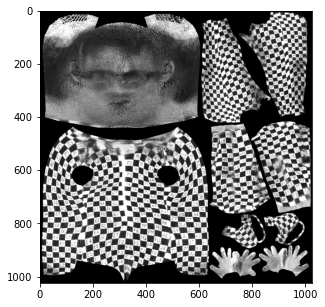

In [7]:
model = None
torch.cuda.empty_cache()
batch_size = 1
n_batch = n_forwards // batch_size
texturemap_path = r'./14d_data/output/200515_lessShadingInfo/texturemap_averaged.npy'
# texturemap_path = None
model = Model_normal(device, texturemap_path=texturemap_path, texturemap_shape=texturemap_shape, img_dir=img_dir, cam_params=cams_torch, image_refs=img_refs, mesh_paths=mesh_paths, image_size=image_size, clean_plates=clean_plates, batch_size=batch_size, n_batch=n_batch)
texture_maps = model.texture_map
print('texture_map: {:,.2f}=={:,.2f} Mb'.format(texture_maps.element_size() * texture_maps.nelement() * 0.000001, texture_maps.detach().cpu().numpy().nbytes*0.000001))
texture_maps_np = texture_maps.detach().cpu().numpy()
print('  {} {:,.2f}Mb {} {}'.format(texture_maps.shape, texture_maps_np.nbytes*0.000001, texture_maps.dtype, np.max(texture_maps_np)))
img_name = list(model.image_refs.keys())[0]
img = model.image_refs[img_name][0]
print('ref image: {}, {:,.2f} Mb'.format(img.shape, img.element_size() * img.nelement() * 0.000001))


plt.figure(figsize=(5, 5))
plt.imshow(texture_maps_np.squeeze(), cmap='gray', vmin=0, vmax=1)
plt.show()

In [24]:
torch.cuda.empty_cache()
model.deform_meshes()
# model.set_mesh_texturemap()
images_with_bg = np.empty((n_batch*batch_size, model.image_size, model.image_size, 1))
images = np.empty((n_batch*batch_size, model.image_size, model.image_size, 4))
images_target = np.empty((n_batch*batch_size, model.image_size, model.image_size, 3))
losses = []
print('{} renders ({} images, {} cams), n_batch={}, batch_size={}'.format(n_forwards, len(img_names), len(cams), n_batch, batch_size))
for batch_idx in range(n_batch):
    print(batch_idx)
    i0 = batch_idx*batch_size
    i1 = i0 + batch_size
    
    imgs, l, l_dict = model(batch_idx, learn_texturemap=False, learn_deform=False)
    losses.append(l.detach().cpu().data)

    images_with_bg[i0:i1] = imgs['currents_with_bg'].detach().cpu().numpy()
    images[i0:i1] = imgs['currents'].detach().cpu().numpy()
    images_target[i0:i1] = imgs['targets'].detach().cpu().numpy()


32 renders (2 images, 16 cams), n_batch=32, batch_size=1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


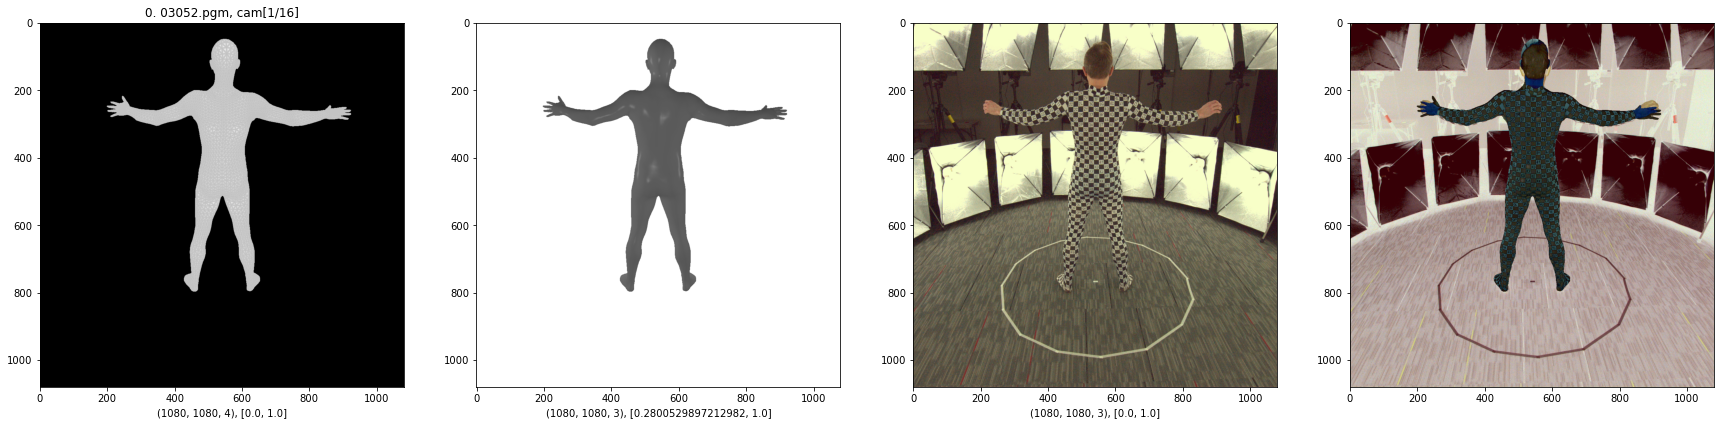

In [25]:
for img_idx in range(len(img_names)):
    for cam_idx in range(len(cams)):
        i = img_idx*len(cams) + cam_idx
        fig, ax = plt.subplots(1, 4, figsize=(30, 10))
        ax = ax.ravel()
        img = cv2.flip(images[i], -1)
        ax[0].imshow(img[..., 3], cmap='gray')
        ax[0].set_title('{}. {}.pgm, cam[{}/{}]'.format(i, img_names[img_idx], cam_idx+1, len(cams)))
        ax[0].set_xlabel('{}, [{}, {}]'.format(img.shape, np.min(img), np.max(img)))
        
        img = cv2.flip(images[i][..., :3], -1)
        ax[1].imshow(img, cmap='gray')
        ax[1].set_xlabel('{}, [{}, {}]'.format(img.shape, np.min(img), np.max(img)))
        
        img2 = cv2.flip(images_target[i], -1)
        ax[2].imshow(cv2.cvtColor((255*img2).astype(np.uint8), cv2.COLOR_BGR2RGB))
        ax[2].set_xlabel('{}, [{}, {}]'.format(img2.shape, np.min(img2), np.max(img2)))
        
        diff = np.abs(img2 - img[..., :3])
        ax[3].imshow(diff)
        
        plt.show()
        break
    break
    print()


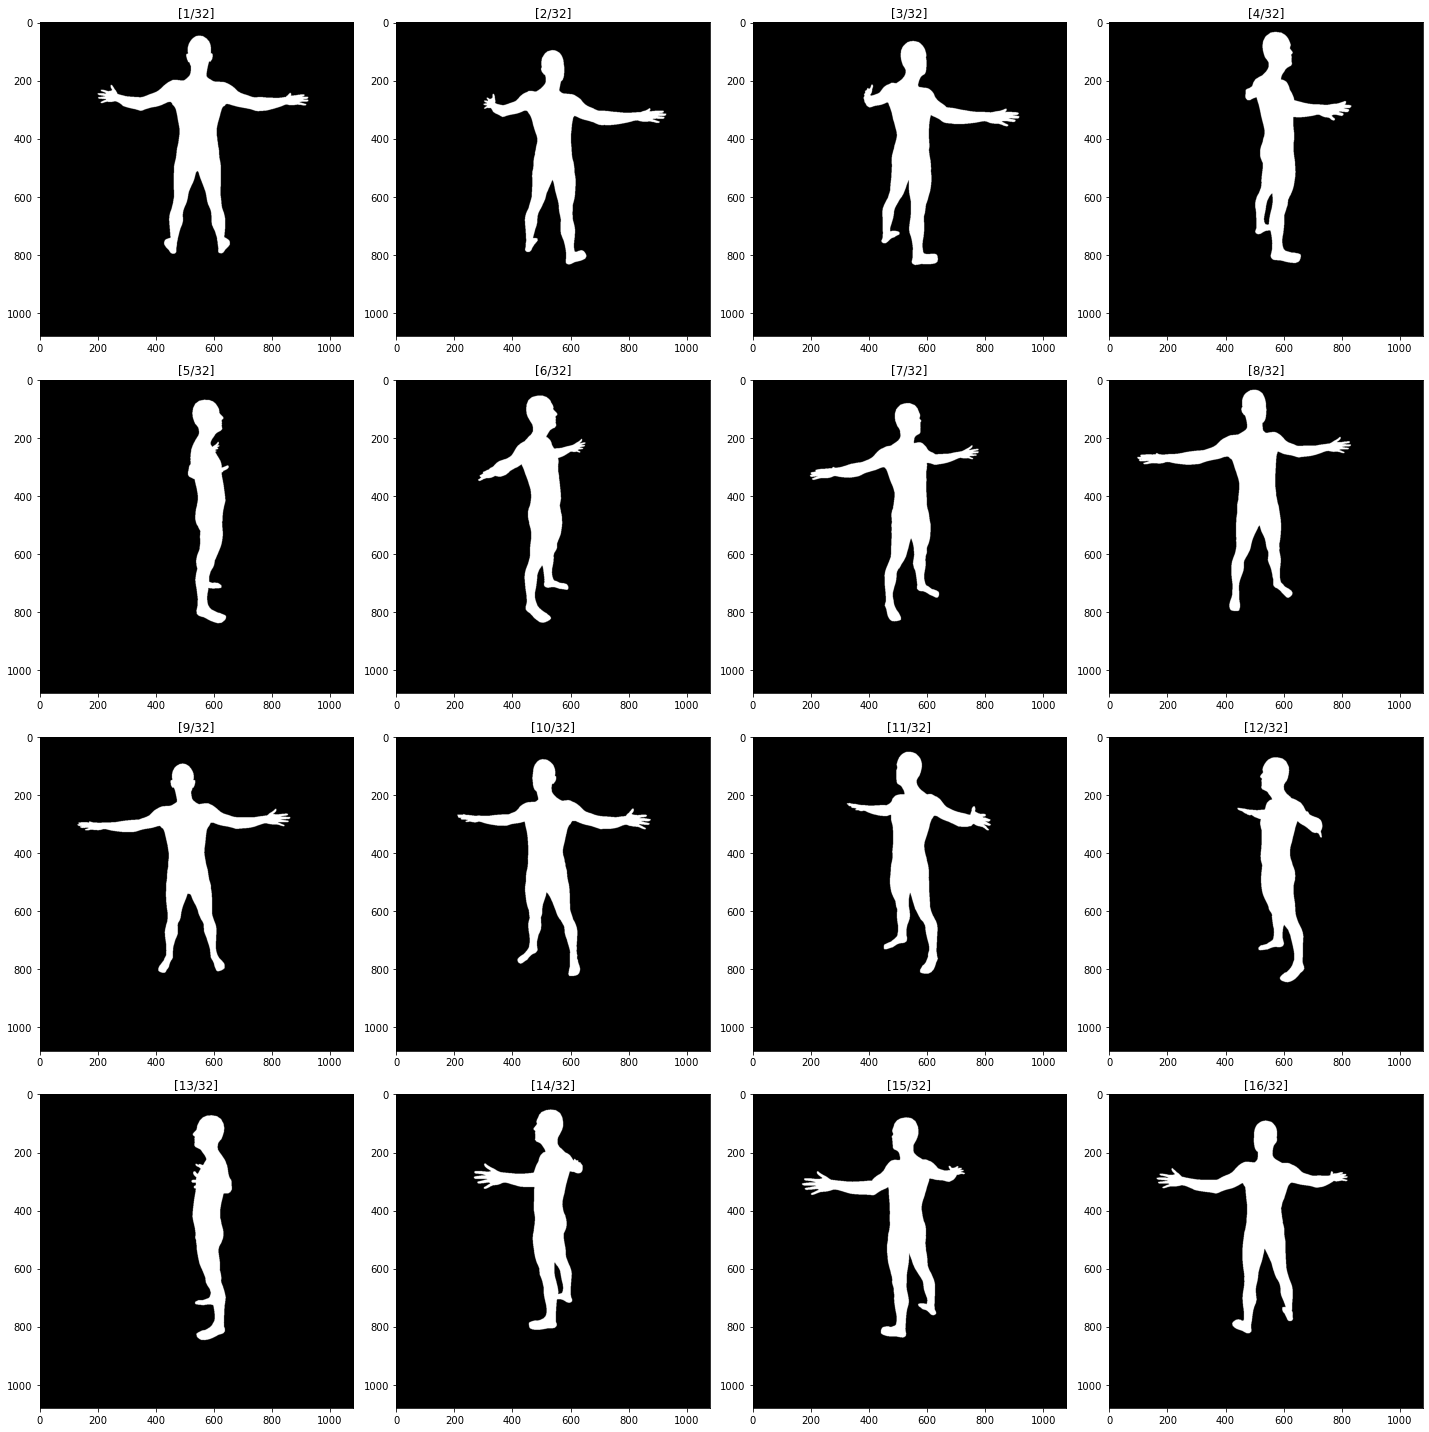

In [26]:
images_binary = np.where(images[..., 3] > 0, 1, 0)

fig, ax = plt.subplots(4, 4, figsize=(20, 20), tight_layout=True)
ax = ax.ravel()
for i in range(len(ax)):
    ax[i].imshow(cv2.flip(images_binary[i], -1), cmap='gray')
    ax[i].set_title('[{}/{}]'.format(i+1, len(images)))
plt.show()

   ./20_data/output/trimaps/trimap_03052_0.png
   ./20_data/output/trimaps/trimap_03052_1.png
   ./20_data/output/trimaps/trimap_03052_2.png
   ./20_data/output/trimaps/trimap_03052_3.png
   ./20_data/output/trimaps/trimap_03052_4.png
   ./20_data/output/trimaps/trimap_03052_5.png
   ./20_data/output/trimaps/trimap_03052_6.png
   ./20_data/output/trimaps/trimap_03052_7.png
   ./20_data/output/trimaps/trimap_03052_8.png
   ./20_data/output/trimaps/trimap_03052_9.png
   ./20_data/output/trimaps/trimap_03052_10.png
   ./20_data/output/trimaps/trimap_03052_11.png
   ./20_data/output/trimaps/trimap_03052_12.png
   ./20_data/output/trimaps/trimap_03052_13.png
   ./20_data/output/trimaps/trimap_03052_14.png
   ./20_data/output/trimaps/trimap_03052_15.png
   ./20_data/output/trimaps/trimap_04917_0.png
   ./20_data/output/trimaps/trimap_04917_1.png
   ./20_data/output/trimaps/trimap_04917_2.png
   ./20_data/output/trimaps/trimap_04917_3.png
   ./20_data/output/trimaps/trimap_04917_4.png
   ./20

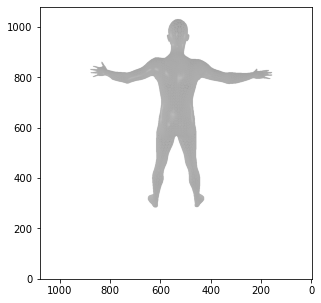

0 3 1


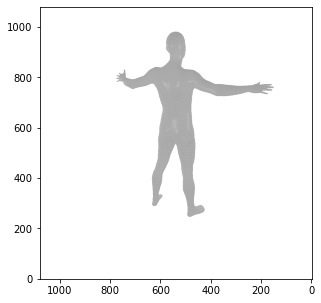

0 3 1


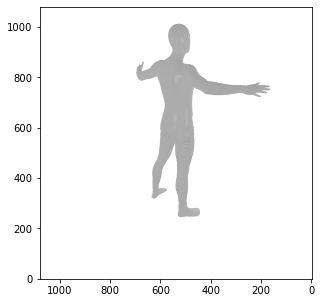

0 3 1


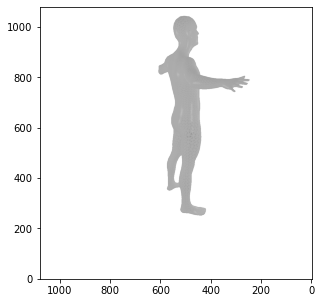

0 3 1


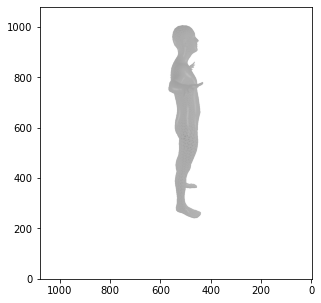

0 3 1


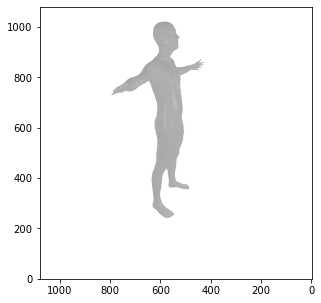

0 3 1


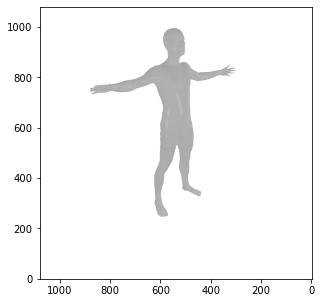

0 3 1


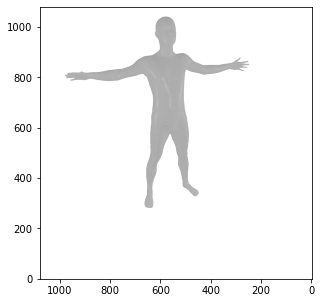

0 3 1


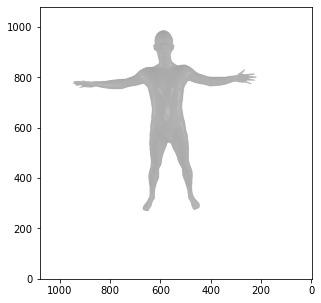

0 3 1


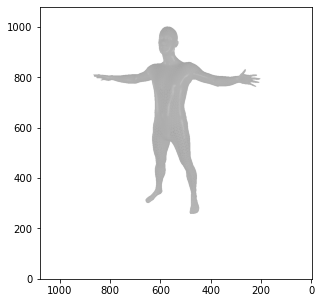

0 3 1


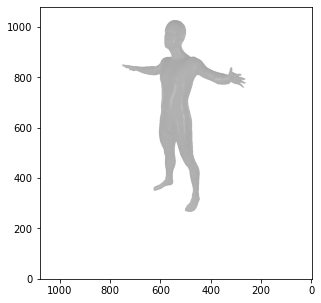

0 3 1


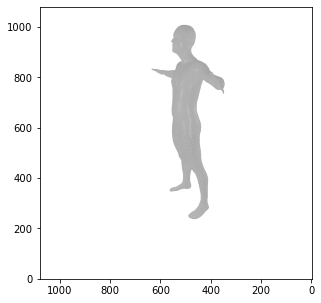

0 3 1


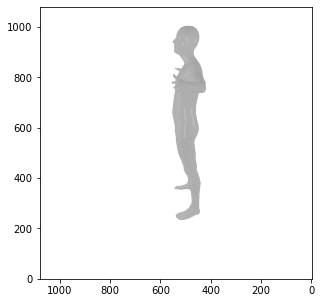

0 3 1


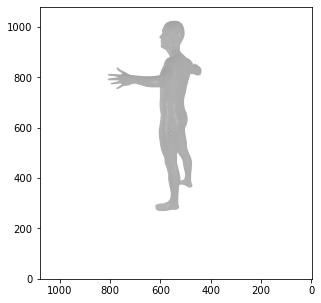

0 3 1


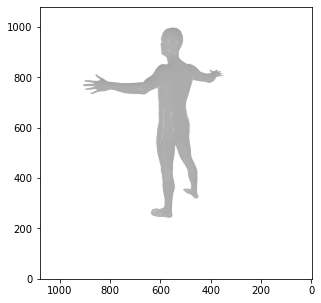

0 3 1


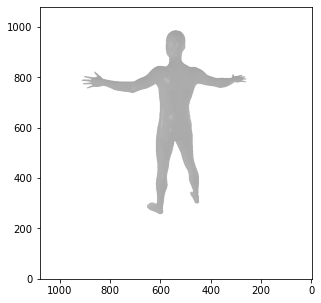

In [65]:
def findSignificantContour(edgeImg):
    edgeImg = (edgeImg*255.0).astype(np.uint8)
    contours, hierarchy = cv2.findContours(
        edgeImg,
        cv2.RETR_TREE,
        cv2.CHAIN_APPROX_SIMPLE
    )
     # Find level 1 contours
    level1Meta = []
    if hierarchy is None:
        print('* hierarchy is None')
        largestContour = None
    else:
        for contourIndex, tupl in enumerate(hierarchy[0]):
            # Each array is in format (Next, Prev, First child, Parent)
            # Filter the ones without parent
            if tupl[3] == -1:
                tupl = np.insert(tupl.copy(), 0, [contourIndex])
                level1Meta.append(tupl)
         # From among them, find the contours with large surface area.
        contoursWithArea = []
        for tupl in level1Meta:
            contourIndex = tupl[0]
            contour = contours[contourIndex]
            area = cv2.contourArea(contour)
            contoursWithArea.append([contour, area, contourIndex])
        contoursWithArea.sort(key=lambda meta: meta[1], reverse=True)
        largestContour = contoursWithArea[0][0]
    return largestContour

def gen_trimap(image, contour):
    """
    image: float 1.0
    output: 3 channels of binary tensor
            Foreground pixels are pixels where the trimap has value 1.0. Background pixels are pixels where the trimap has value 0.
    """
    # Draw the contour on the original image
    contour_img = np.copy(image*255)
    contour_img = np.dstack([contour_img, contour_img, contour_img]).astype(np.uint8)
    cv2.drawContours(contour_img, [contour], 0, (111, 0, 0), 21, maxLevel=0)
    cnt_r = contour_img[..., 0]
    cnt_g = contour_img[..., 1]
    cnt_b = contour_img[..., 2]
    
    trimap = np.zeros((contour_img.shape[0], contour_img.shape[1])).astype(np.float32)
    trimap[cnt_r == 111] = 0.5
    trimap[cnt_g == 255] = 1.0
    trimap[cnt_r == 0] = 0.0
    return trimap

out_dir = './20_data/output/trimaps'
trimaps = np.empty(images_binary.shape).astype(np.float32)
for i in range(len(images_binary)):
    contour = findSignificantContour(images_binary[i])
    trimap = gen_trimap(images_binary[i], contour)
    trimaps[i] = trimap
    
    img_name = image_data[i]['img_name']
    cam_idx = image_data[i]['cam_idx']
    out_path = out_dir + '/trimap_{}_{}.png'.format(img_name, cam_idx)
    cv2.imwrite(out_path, (255*trimap).astype(np.uint8))
    print('  ', out_path)

for cam_idx in range(0, 16):
    print(cv2.GC_BGD, cv2.GC_PR_FGD , cv2.GC_FGD)
    plt.figure(figsize=(5, 5))
    plt.imshow(images[cam_idx], cmap='gray')
#     plt.imshow(trimaps[cam_idx], cmap='gray', alpha=1.0)
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    plt.show()

# cv2 Grabcut

In [50]:
# images_cut = []
# for img_idx in range(len(images)):
#     image = (255*images[img_idx, ..., :3]).astype(np.uint8)
#     mask = np.zeros(image.shape[:2], np.uint8)
#     bgdModel = np.zeros((1, 65), np.float64)
#     fgdModel = np.zeros((1, 65), np.float64)
#     rect = (0, 0, mask.shape[0] - 1, mask.shape[1] - 1)

#     cv2.grabCut(image, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

#     mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
#     img = images_target[img_idx]*mask2[:,:,np.newaxis]
#     images_cut.append(img)
# print('Done:', len(images_cut))

In [51]:
# for i in range(len(images_cut)):
#     img = images_cut[i].squeeze()
#     img_target = images_target[i].squeeze()
#     fig, ax = plt.subplots(1, 3, figsize=(30, 10), tight_layout=True)
#     ax[0].imshow(cv2.flip(img, -1), cmap='gray')
#     ax[1].imshow(cv2.flip(img_target, -1), cmap='gray')
#     diff = np.abs(img - img_target)
#     ax[2].imshow(cv2.flip(diff, -1))
#     plt.show()
#     break

# Matting

In [52]:
img_idx = 0

image = (images_target[img_idx]).astype(np.float64)
print('1 image:', image.shape, image.dtype, np.max(image))

# image = np.dstack([image, image, image])
print('2 image:', image.shape, image.dtype, np.max(image))
print('trimap:', trimap.shape, trimap.dtype, np.max(trimap))

trimap = np.expand_dims(trimaps[img_idx], axis=-1).astype(np.float64)

# estimate alpha from image and trimap
alpha = pymatting.estimate_alpha_cf(image, trimap)
alpha = alpha.squeeze()

# make gray background
new_background = np.zeros(image.shape)
new_background[:, :] = [0.5, 0.5, 0.5]

# estimate foreground from image and alpha
foreground, background = pymatting.estimate_foreground_ml(image, alpha, return_background=True)

# blend foreground with background and alpha, less color bleeding
new_image = pymatting.blend(foreground, new_background, alpha)


# save cutout
cutout = pymatting.stack_images(foreground, alpha)

# just blending the image with alpha results in color bleeding
color_bleeding = pymatting.blend(image, new_background, alpha)
grid = pymatting.make_grid([color_bleeding, new_image])


1 image: (1080, 1080, 3) float64 1.0
2 image: (1080, 1080, 3) float64 1.0
trimap: (1080, 1080) float32 1.0


(1080, 1080, 3)


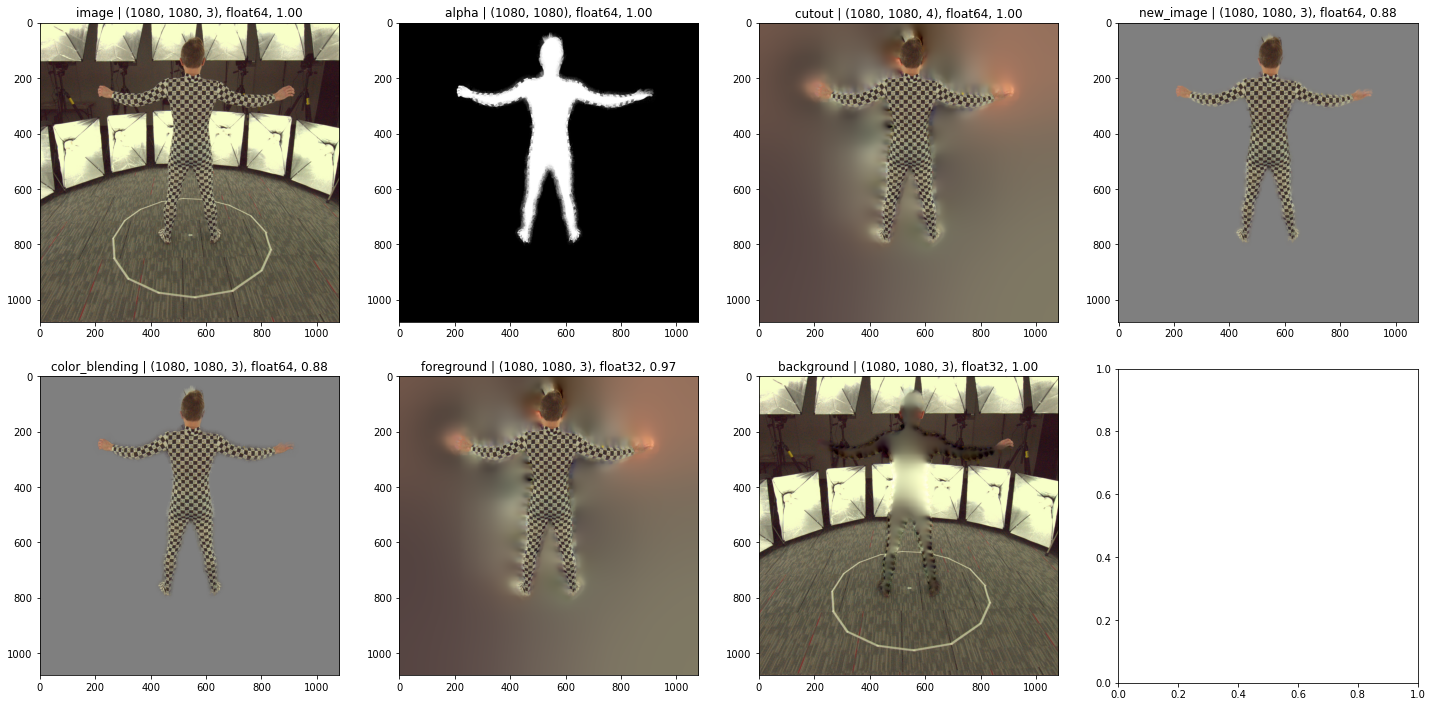

In [94]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10), tight_layout=True)
ax = ax.ravel()
imgs = [image, alpha, cutout, new_image, color_bleeding, foreground, background]
titles = ['image', 'alpha', 'cutout', 'new_image', 'color_blending', 'foreground', 'background']
for i in range(len(imgs)):
    if len(imgs[i].shape) == 3 and imgs[i].shape[-1] >= 3:
        img = cv2.flip(cv2.cvtColor((255*imgs[i]).astype(np.uint8), cv2.COLOR_BGR2RGB), -1)
        ax[i].imshow(img)
    else:
        img = (255*imgs[i]).astype(np.uint8)
#         _, img = cv2.threshold(img, 10, 255,cv2.THRESH_BINARY)
        ax[i].imshow((cv2.flip(img, -1)), cmap='gray')
    ax[i].set_title('{} | {}, {}, {:.2f}'.format(titles[i], imgs[i].shape, imgs[i].dtype, np.max(imgs[i])))
plt.show()

In [ ]:
assert(False)

In [ ]:
print('image:', image.shape, image.dtype, np.max(image))
print('alpha:', alpha.shape, alpha.dtype, np.max(alpha))
foreground = pymatting.estimate_foreground_ml(image, alpha.squeeze())

cutout = pymatting.stack_images(foreground, alpha)

plt.figure(figsize=(20, 20))
plt.imshow(cv2.flip(cutout, -1))
plt.show()

# Example: simple

In [ ]:
from pymatting import cutout

out_path = "./20_data/input/lemur_cutout.png"
cutout(
    # input image path
    "./20_data/input/lemur.png",
    # input trimap path
    "./20_data/input/lemur_trimap.png",
    # output cutout path
    out_path
    )
img = cv2.imread(out_path)
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.show()

# Example: expert_example.py

In [ ]:
from pymatting import *
import numpy as np
import scipy.sparse

scale = 1.0

img = load_image("./20_data/input/lemur.png", "RGB", scale, "box")
tri = load_image("./20_data/input/lemur_trimap.png", "GRAY", scale, "nearest")

# height and width of trimap
h, w = tri.shape[:2]

# calculate laplacian matrix
L = cf_laplacian(img)

# decompose trimap
is_fg, is_bg, is_known, is_unknown = trimap_split(tri)

# constraint weight
lambda_value = 100.0

# build constraint pixel selection matrix
c = lambda_value * is_known
C = scipy.sparse.diags(c)

# build constraint value vector
b = lambda_value * is_fg

# build linear system
A = L + C

# build ichol preconditioner for faster convergence
A = A.tocsr()
A.sum_duplicates()
M = ichol(A)

# solve linear system with conjugate gradient descent
x = cg(A, b, M=M)

# clip and reshape result vector
alp = np.clip(x, 0.0, 1.0).reshape(h, w)

cutout = stack_images(img, alp)

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(cutout, cmap='gray')
plt.show()

# Example: advanced_example.py

In [ ]:
from pymatting import *
import numpy as np

scale = 1.0

image = load_image("./20_data/input/lemur.png", "RGB", scale, "box")
trimap = load_image("./20_data/input/lemur_trimap.png", "GRAY", scale, "nearest")

# estimate alpha from image and trimap
alpha = estimate_alpha_cf(image, trimap)

# make gray background
new_background = np.zeros(image.shape)
new_background[:, :] = [0.5, 0.5, 0.5]

# estimate foreground from image and alpha
foreground, background = estimate_foreground_ml(image, alpha, return_background=True)

# blend foreground with background and alpha, less color bleeding
new_image = blend(foreground, new_background, alpha)

# save results in a grid
images = [image, trimap, alpha, new_image]
grid = make_grid(images)
save_image("./20_data/input/lemur_grid.png", grid)

# save alpha
save_image("./20_data/input/lemur_alpha.png", alpha)

# save foreground
save_image("./20_data/input/lemur_foreground.png", foreground)

# save background
save_image("./20_data/input/lemur_background.png", background)

# save cutout
cutout = stack_images(foreground, alpha)
save_image("./20_data/input/lemur_cutout.png", cutout)

# just blending the image with alpha results in color bleeding
color_bleeding = blend(image, new_background, alpha)
grid = make_grid([color_bleeding, new_image])

print('Done:', grid.shape)

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(grid)
plt.show()